In [6]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
plt.rcParams['figure.figsize'] = (8, 8)

In [7]:
# Which calibration type to analyse.
calibType = 'crosstalk'

# This cell should be edited to match the data to be inspected.
afwDisplay.setDefaultBackend("astrowidgets")
cameraName = 'LATISS'
genCollection = 'u/czw/DM-30170/crosstalkGen.20211206a'
correctedCollection = 'u/czw/DM-30170/verifyCrosstalk.20211208a'

In [8]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[genCollection, correctedCollection])
camera = butler.get('camera', instrument=cameraName)

In [9]:
crosstalk = butler.get(calibType, instrument='LATISS', detector=0, collections=genCollection)
residualCrosstalk = butler.get(calibType, instrument='LATISS', detector=0, collections=correctedCollection)

In [10]:
runStats = butler.get('verifyCrosstalkStats', instrument=cameraName, collections=correctedCollection)
runSuccess = runStats.pop('SUCCESS')

In [11]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

ValueError: not enough values to unpack (expected 3, got 2)

NameError: name 'ptc' is not defined

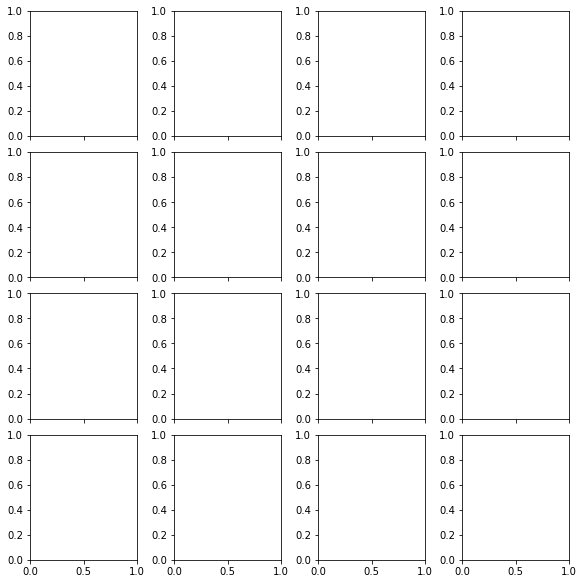

In [10]:
# Plot raw cross-correlation values
inputSelection = 11
iterator = 0
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=False, figsize=[8.0, 8.0], constrained_layout=True)
for ampName in sorted(set(ptc.ampNames)):
    covariance = ptc.covariances[ampName][inputSelection]
    axes[iterator // 4, iterator % 4].set_aspect("equal")
    axes[iterator // 4, iterator % 4].imshow(np.log10(np.abs(covariance)))
    axes[iterator // 4, iterator % 4].set_title(f"Amp {ampName} {covariance[0][0]:.2e}")

    iterator += 1
fig.suptitle(f"Measured covariance {ptc.inputExpIdPairs[ampName][inputSelection]}")
plt.show()

In [11]:
#Plot as a function of flux?  This duplicates debug plots, but maybe helpful?
XX = np.arange(-20, -11, 0.1)

for exposureId in runStats.keys():
    for detector in camera:
        detStats = butler.get("verifyBfkDetStats", instrument=cameraName, detector=detector.getId(),
                             exposure=exposureId, visit=exposureId)
        print(detStats['CATALOG']['BRIGHT_SLOPE'])
        M = detStats['CATALOG']['MAGNITUDES']
        D = detStats['CATALOG']['SIZE_DIFF']
        mask = np.isfinite(M) * np.isfinite(D)
        
        p0 = [0.0, 0.0, 0.0]
        ZZ = least_squares(residual, p0, args=(np.array(M)[mask], np.array(D)[mask]), loss='cauchy')
        pf = np.polyfit(np.array(M)[mask], np.array(D)[mask], 2)
        
        plt.scatter(detStats['CATALOG']['MAGNITUDES'], detStats['CATALOG']['SIZE_DIFF'])
        plt.plot(XX, np.polyval(pf, XX), label=f"polynomial (N=2) {pf}")
        # plt.plot(XX, np.polyval(ZZ.x, XX), label="robust")
        plt.plot(XX, f(XX, *ZZ.x), label=f"exponential {ZZ.x}")
        plt.ylim(-1, 5)
        plt.legend()

        plt.title(exposureId)
        plt.show()

NameError: name 'runStats' is not defined

In [12]:
display = afwDisplay.Display(dims=(1000, 1000))
display.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [13]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

AttributeError: 'CrosstalkCalib' object has no attribute 'getImage'

In [14]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue

            detId = detector.getId()
            residual = butler.get('verifyBiasProc', instrument=cameraName, exposure=exposureId, detector=detId)
            detStats = butler.get('verifyBiasDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
            display.mtv(residual)    

            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

NameError: name 'runStats' is not defined

In [12]:
# Plot focal plane, and display number of amp-level failures per detector.
# TODO: increase plot level to amplifier.
utils.plotFailures(runStats, camera, scaleFactor=8)

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
runStats

{'RXX_S00': {'FAILURES': ['RXX_S00 NO_SIGNIFICANT_DETECTION']}}